# Feature Importance of MNIST Using HAT

## Prepare the Dataset

In [1]:
from pathlib import Path

import torch
import torchvision

example_dir_path = Path().resolve()
data_dir_path = Path.joinpath(example_dir_path, "data")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create MNIST datasets and dataloaders
trn_dataset = torchvision.datasets.MNIST(
    root=data_dir_path,
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)
tst_dataset = torchvision.datasets.MNIST(
    root=data_dir_path,
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)
trn_dataloader = torch.utils.data.DataLoader(
    trn_dataset,
    batch_size=32,
    shuffle=True,
    pin_memory=True if device.type == "cuda" else False,
    num_workers=4 if device.type == "cuda" else 0,
)
tst_dataloader = torch.utils.data.DataLoader(
    tst_dataset,
    batch_size=32,
    shuffle=False,
    pin_memory=True if device.type == "cuda" else False,
    num_workers=4 if device.type == "cuda" else 0,
)

## Define the Model with Input Mask

In [2]:
import torch.nn as nn

from hat import HATPayload, HATConfig
from hat.modules import HATMasker


class MaskedLinearModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.hat_config = HATConfig(num_tasks=1, init_strat="dense")
        self.masker = HATMasker(
            num_features=784,
            hat_config=self.hat_config,
        )
        self.seq = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, pld: HATPayload):
        pld = pld.forward_by(self.masker)
        return self.seq(pld.data)

    def plot_feature_importance(self, *args, **kwargs):
        return self.masker.plot_feature_importance(*args, **kwargs)


net = MaskedLinearModule()

## Define the Training and Evaluation Functions

In [3]:
from hat.utils import get_hat_mask_scale, get_hat_reg_term


learning_rate = 0.01
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)


def train(
    num_epochs: int,
    regularization_factor: float,
):
    net.train()
    for _ in range(num_epochs):
        for __i, (__images, __targets) in enumerate(trn_dataloader):
            optimizer.zero_grad()
            __images = __images.view(-1, 784).to(device)
            __targets = __targets.to(device)
            __progress = __i / (len(trn_dataloader) - 1)
            __mask_scale = get_hat_mask_scale(
                strat="cosine",
                max_trn_mask_scale=net.hat_config.max_trn_mask_scale,
                progress=__progress,
            )
            __pld = HATPayload(
                data=__images,
                task_id=0,
                mask_scale=__mask_scale,
            )
            __logits = net(__pld)
            __loss = nn.functional.cross_entropy(__logits, __targets)
            __reg = get_hat_reg_term(
                module=net,
                strat="uniform",
                task_id=0,
                mask_scale=__mask_scale,
                forgive_quota=False,
            )
            __loss += regularization_factor * __reg
            __loss.backward()
            optimizer.step()


def evaluate() -> float:
    net.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for __images, __targets in tst_dataloader:
            __images = __images.view(-1, 784).to(device)
            __targets = __targets.to(device)
            __pld = HATPayload(
                data=__images,
                task_id=0,
                mask_scale=1.0,
            )
            __logits = net(__pld)
            __predicted = torch.argmax(__logits, dim=1)
            total += __targets.size(0)
            correct += (__predicted == __targets).sum().item()
    return correct / total

## Train the Model without HAT Regularization

In [4]:
pretrain_epochs = 10
train(num_epochs=pretrain_epochs, regularization_factor=0.0)
print(f"Accuracy after Training without Regularization: {evaluate():.4f}")

Accuracy after Training without Regularization: 0.9672


## Train the Model with increasing HAT Regularization

In [5]:
import numpy as np

from tqdm import tqdm

num_trails = 500
num_epochs_per_trial = 1
max_reg_factor = 20.0

trial_acc = []
feature_importance = []
trial_reg_factor = np.linspace(
    start=0,
    stop=max_reg_factor,
    num=num_trails,
)

for __r in tqdm(trial_reg_factor):
    train(num_epochs=num_epochs_per_trial, regularization_factor=__r)
    __curr_mask = net.masker.get_binary_mask(0).data.cpu().float()
    feature_importance.append(__curr_mask)
    trial_acc.append(evaluate())

100%|██████████| 1000/1000 [2:11:21<00:00,  7.88s/it] 


## Plot the Results

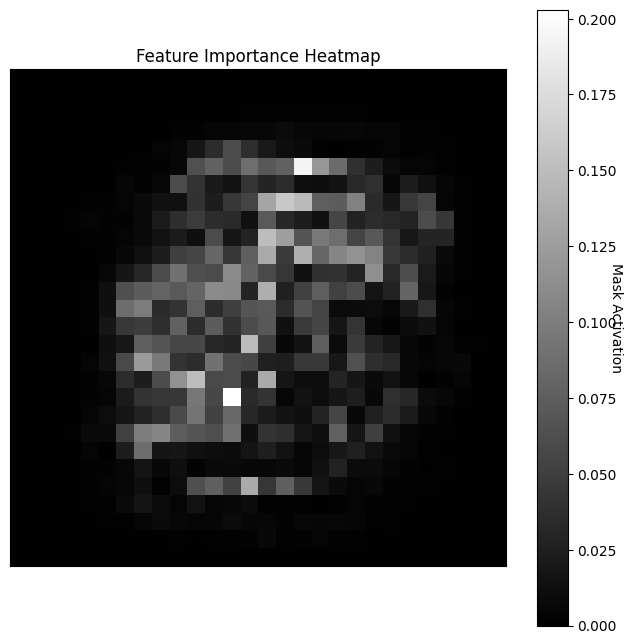

In [6]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(8, 8))
# ax.imshow(feature_importance.reshape(28, 28))
ax.imshow(
    torch.stack(feature_importance).mean(dim=0).reshape(28, 28),
    cmap="gray",
)
ax.set_xticks([])
ax.set_yticks([])
cbar = ax.figure.colorbar(ax.images[0], ax=ax)
cbar.ax.set_ylabel("Mask Activation", rotation=-90)
plt.title("Feature Importance Heatmap")
plt.show()
plt.close()

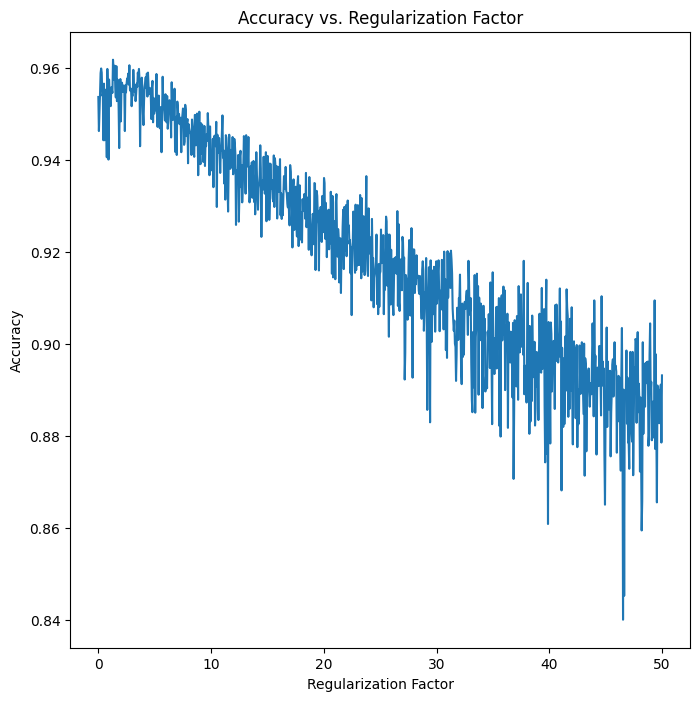

In [7]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(trial_reg_factor, trial_acc)
ax.set_xlabel("Regularization Factor")
ax.set_ylabel("Accuracy")
plt.title("Accuracy vs. Regularization Factor")
plt.show()
plt.close()

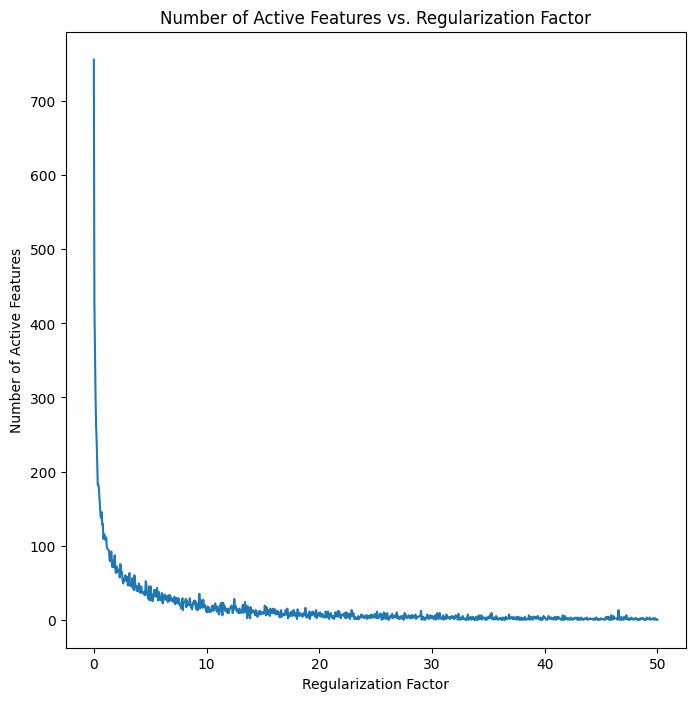

In [8]:
# Plot the number of active features over time

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(trial_reg_factor, torch.stack(feature_importance).sum(dim=1))
ax.set_xlabel("Regularization Factor")
ax.set_ylabel("Number of Active Features")
plt.title("Number of Active Features vs. Regularization Factor")
plt.show()
plt.close()